<h1><center>IEEE's The Blue Sky Challenge</center></h1>

A number of factors in the air can have an impact on its quality. The role of temperature  and carbon monoxide in air quality is vital. The following issue that may be addressed in order to make such systems smarter:

<b>Temporal forecasting of temperature and Carbon Monoxide (CO)</b> sensor data one day ahead: It can assist the general public and government officials in anticipating trends early in order to make timely decisions and take preventative actions.

### Installing necessary libraries

Please comment this code after first installation (Add '#' in the start)

In [1]:
!pip install xgboost

### Importing Required Libraries 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
warnings.filterwarnings("ignore")

### Reading the Dataset

In [3]:
#Eliminating the delimiters while importing
dataset=pd.read_csv('AirQuality.csv', sep=";") 
df=dataset.copy()
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


### Trimming to the required columns and rows
<b>Initial Training Data Period</b>: 7 days from 11/03/2004 00.00.00 to 17/03/2004 23.00.00

<b>Testing Data Period</b>:          7 days from 18/03/2004 00.00.00 to 24/03/2004 23.00.00

Each day of the training and test data period have 24 data points starting from 00.00.00 to 23.00.00.

In [4]:
#Trimming the Dataset from 11/03/2004 to 24/03/2004
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y')
df=df[(df.Date >= '2004-03-11' ) & (df.Date < '2004-03-25')]

#Trimming the Dataset to the required columns
df1=df[['Date','Time','CO(GT)','T']];
df1.head()

,Date,Time,CO(GT),T
6,2004-03-11,00.00.00,"1,2","11,3"
7,2004-03-11,01.00.00,1,"10,7"
8,2004-03-11,02.00.00,"0,9","10,7"
9,2004-03-11,03.00.00,"0,6","10,3"
10,2004-03-11,04.00.00,-200,"10,1"


### Cleaning the Dataset

The whole format of date and time complicates the prediction, instead just the day and hour are extracted

In [5]:
df1['Day']= df1['Date'].dt.day 
df1['Hour']=df1['Time'].apply(lambda x: int(x.split('.')[0]))
df1.head()

,Date,Time,CO(GT),T,Day,Hour
6,2004-03-11,00.00.00,"1,2","11,3",11,0
7,2004-03-11,01.00.00,1,"10,7",11,1
8,2004-03-11,02.00.00,"0,9","10,7",11,2
9,2004-03-11,03.00.00,"0,6","10,3",11,3
10,2004-03-11,04.00.00,-200,"10,1",11,4


Notice that CO concentration and Temperature have error in their entries. Correcting them:

In [6]:
df1["CO(GT)"]=(df1["CO(GT)"].str.replace(',','.')).astype(float)
df1["T"]=(df1["T"].str.replace(',','.')).astype(float)

Checking if there are any nan values

In [7]:
df1.isnull().sum()

Date      0
Time      0
CO(GT)    0
T         0
Day       0
Hour      0
dtype: int64

Notice that there are negative values(-200) in concentration of CO. Dropping them and also resetting the row indices

In [8]:
dfs = df1

i = df1[ (df1["CO(GT)"] < 0)].index
df1.drop(i, inplace=True)
df1= df1.reset_index(drop=True)

### Visualisation of Data

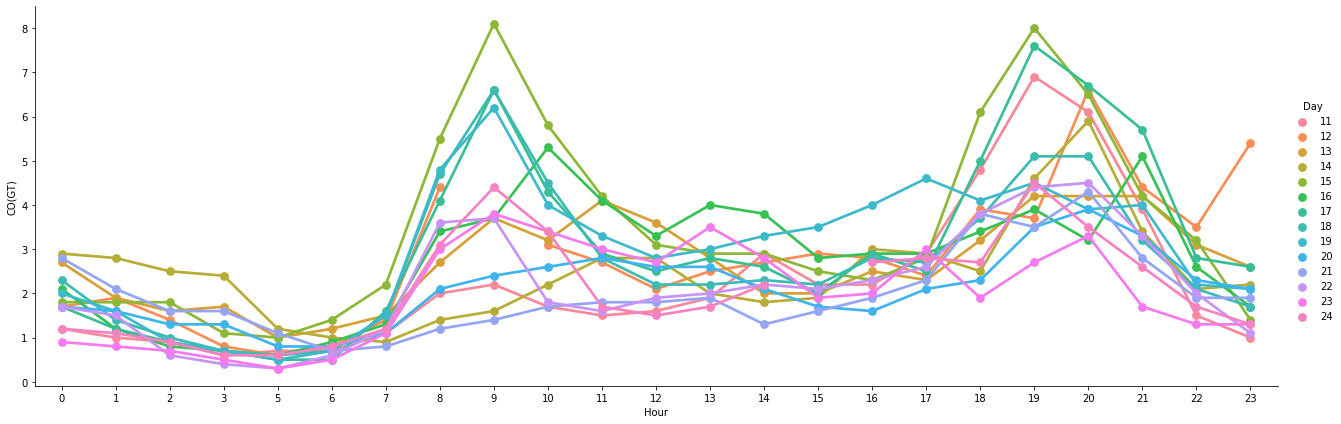

In [9]:
#CO Concentration every hour wrt to each given day
sns.catplot(x="Hour", y="CO(GT)", hue='Day', data=df1, kind='point', height=6, aspect=3)

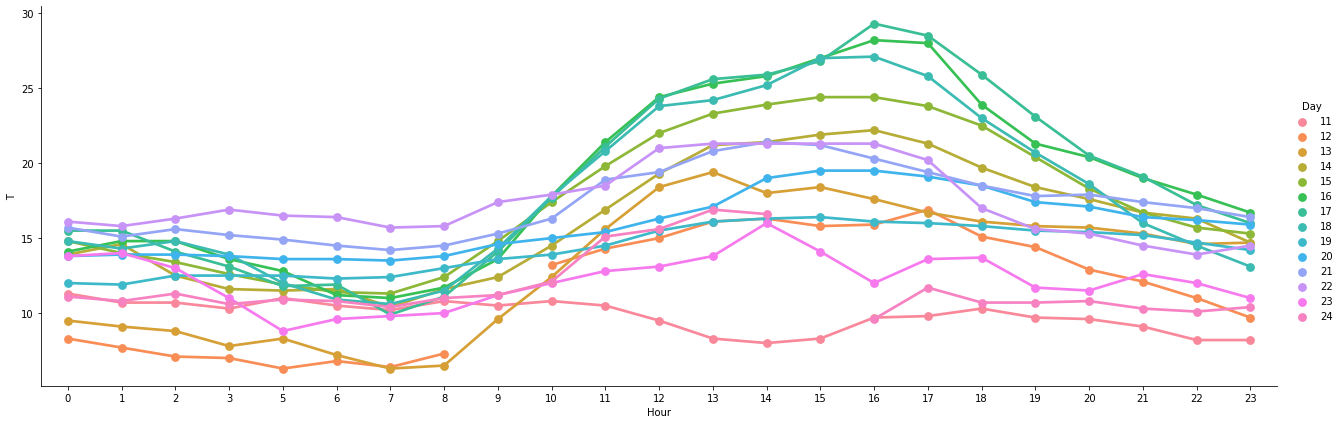

In [10]:
#Temperature every hour wrt to each given day
sns.catplot(x="Hour", y="T", hue='Day', data=df1, kind='point', height=6, aspect=3)

### Train-Test Spliting

Initially, train the machine learning model using 7 days data from 11/03/2004 00.00.00 to 17/03/2004 23.00.00.

Perform temporal forecasting (one-day ahead forecasting) for the 8th day using 7 days of data. Compare the forecast values with the real sensor data and perform performance evaluation using the metrics Mean Absolute Percentage Error (MAPE). <b>Perform the temporal forecasting for the 9th day by updating the training database from the 8th day sensor measurements</b>. Compute the forecasting performance metric and follow the same procedure for the rest.

In [11]:
X_1, X_2 = df1[(mask:=df1.Day <= 17)].copy(), df1[~mask].copy()

c = X_1.columns.tolist()[2:]
Train = X_1[c]
Test = X_2[c]

Train.reset_index(drop=True,inplace=True)
Test.reset_index(drop=True,inplace=True)

In [12]:
x_train = Train.drop(['CO(GT)', 'T'],axis=1)
x_test =  Test.drop(['CO(GT)', 'T'],axis=1)

y_test =  Test[['CO(GT)','T']]
y_train = Train[['CO(GT)','T']]

In [13]:
y_train

,CO(GT),T
0,1.2,11.3
1,1.0,10.7
2,0.9,10.7
3,0.6,10.3
4,0.7,11.0
...,...,...
155,7.6,23.1
156,6.7,20.5
157,5.7,19.1
158,2.8,17.2


### Importing the Model

In [14]:
import xgboost as xgb

#### Listing out possible range of the Regressor's paramaters

In [15]:
params={
 "estimator__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "estimator__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "estimator__min_child_weight" : [ 1, 3, 5, 7 ],
 "estimator__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "estimator__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

#### Hyperparameter tuning using RandomizedSearch CV

Providing the XGBRegressor inside a MultiOutput Regressor since we are predicting both T and CO(GT) together

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
classifier=MultiOutputRegressor(xgb.XGBRegressor())
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    4.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         enable_categorical=False,
                                                                         gamma=None,
                                                                         gpu_id=None,
                                                                         importance_type=None,
                                                                         interaction_constraints=None,
        

In [17]:
random_search.best_estimator_

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False, gamma=0.3,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='re

#### Fitting and Predicting
Passing the Regressor with the best paramters into a <i>for loop</i>, that iterates and predicts for the 18th day, takes the real values of 18th day and pushes into the training dataset to predict the next day and continue the process. 

In [18]:
UV = x_test['Day'].unique()
temp = 0;
result =[]
model1 = MultiOutputRegressor(xgb.XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7,
                                            enable_categorical=False, gamma=0.3,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=1,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None))
for i in UV:

    model1.fit(x_train,y_train)
    testx = x_test[x_test["Day"] == i]
    testy = y_test[temp:temp+len(testx)]
    test1 = testx.to_numpy()
    x_train = x_train.append(testx, ignore_index=True)
    y_train = y_train.append(testy, ignore_index=True)
    resultx = model1.predict(test1)
    result.append(resultx)
    temp += len(testx)
print(result)

[array([[ 2.1103256, 16.177864 ],
       [ 1.9194418, 16.09824  ],
       [ 1.6471273, 15.417482 ],
       [ 1.3936915, 14.642238 ],
       [ 1.2087159, 14.319855 ],
       [ 1.2087159, 13.919968 ],
       [ 1.642653 , 13.403366 ],
       [ 3.5604608, 14.006867 ],
       [ 4.2778187, 15.708034 ],
       [ 3.8092098, 18.587807 ],
       [ 3.3474078, 20.89564  ],
       [ 2.885692 , 22.764547 ],
       [ 2.885692 , 23.637913 ],
       [ 2.885692 , 23.637913 ],
       [ 2.750143 , 24.093891 ],
       [ 2.8421853, 24.531734 ],
       [ 2.8421853, 24.438896 ],
       [ 4.3082304, 22.797989 ],
       [ 5.6160307, 21.446066 ],
       [ 5.6160307, 20.079597 ],
       [ 4.5769515, 19.187767 ],
       [ 2.8520048, 18.223862 ],
       [ 2.6928227, 17.516365 ]], dtype=float32), array([[ 1.9000056 , 15.191443  ],
       [ 1.6159581 , 15.092712  ],
       [ 1.3275661 , 14.56211   ],
       [ 1.0821755 , 13.738068  ],
       [ 0.91926235, 13.256382  ],
       [ 0.91926235, 12.743152  ],
       [ 1.40

### Calculating the MAPE

Using the formula, MAPE = Mean(abs((Actual-Predicted)/Actual)) for each day for both CO and T 

In [19]:
dfnew = pd.DataFrame([], columns=['Day', 'Hours', 'CO (Actual)', 'T(Actual)', 'CO(predicted)', 'T(predicted)', 'C (error)', 'T (error)'])

#creating a datastructure to store the sum of errors and no of samples for that particular day
mape_c = {
    18: [0, 0],
    19: [0, 0],
    20: [0, 0],
    21: [0, 0],
    22: [0, 0],
    23: [0, 0],
    24: [0, 0],
}

mape_t = {
    18: [0, 0],
    19: [0, 0],
    20: [0, 0],
    21: [0, 0],
    22: [0, 0],
    23: [0, 0],
    24: [0, 0],
}

results = []
for i in result:
    for j in i:
        results.append(j)
result = results

In [20]:
#Creating a separate dataframe to Store the predicted values and the error of each hour
for i in range(0, 160):
    cerror = abs(y_test.loc[i, ['CO(GT)']][0] - result[i][0])/y_test.loc[i, ['CO(GT)']][0]
    terror = abs(y_test.loc[i, ['T']][0] - result[i][1])/y_test.loc[i, ['T']][0]
    day = x_test.loc[i, ['Day']][0]
    mape_c[day][0] += cerror
    mape_c[day][1] += 1
    mape_t[day][0] += terror
    mape_t[day][1] += 1
    dfx = pd.DataFrame([[x_test.loc[i, ['Day']][0], x_test.loc[i, ['Hour']][0], y_test.loc[i, ['CO(GT)']][0], y_test.loc[i, ['T']][0], result[i][0], result[i][1], cerror, terror]],columns=['Day', 'Hours', 'CO (Actual)', 'T(Actual)', 'CO(predicted)', 'T(predicted)', 'C (error)', 'T (error)'] )
    dfnew = dfnew.append(dfx, ignore_index=True)

In [21]:
dfnew.to_csv('gradientBoostingResults.csv')

In [22]:
dfnew

,Day,Hours,CO (Actual),T(Actual),CO(predicted),T(predicted),C (error),T (error)
0,18,0,2.3,14.8,2.110326,16.177864,0.082467,0.093099
1,18,1,1.4,14.3,1.919442,16.098240,0.371030,0.125751
2,18,2,1.0,14.8,1.647127,15.417482,0.647127,0.041722
3,18,3,0.7,13.9,1.393692,14.642238,0.990988,0.053398
4,18,5,0.6,12.0,1.208716,14.319855,1.014527,0.193321
...,...,...,...,...,...,...,...,...
155,24,19,4.5,10.7,4.277598,13.967499,0.049423,0.305374
156,24,20,3.5,10.8,4.277598,12.894862,0.222171,0.193969
157,24,21,2.6,10.3,3.258575,12.193491,0.253298,0.183834
158,24,22,1.7,10.1,1.850515,11.359013,0.088538,0.124655


#### Daywise and Average MAPE of CO Concentration and Temperature

In [23]:
mean_mapec = 0
for x in mape_c:
    mean_mapec += mape_c[x][0]/mape_c[x][1]
    print(f"MAPE of CO concentration for day {x} = {mape_c[x][0]/mape_c[x][1]}")

print(f"Mean MAPE of CO: {mean_mapec/7}")
mean_mapet = 0
for x in mape_t:
    mean_mapet += mape_t[x][0]/mape_t[x][1]
    print(f"MAPE of T for day {x} = {mape_t[x][0]/mape_t[x][1]}")
print(f"Mean MAPE of CO: {mean_mapet/7}")

MAPE of CO concentration for day 18 = 0.33940205777189686
MAPE of CO concentration for day 19 = 0.23537511969639524
MAPE of CO concentration for day 20 = 0.38055520461690046
MAPE of CO concentration for day 21 = 0.4299076399001941
MAPE of CO concentration for day 22 = 0.21280266321603533
MAPE of CO concentration for day 23 = 0.3310908610541785
MAPE of CO concentration for day 24 = 0.20915217084953638
Mean MAPE of CO: 0.3054693881578768
MAPE of T for day 18 = 0.11806801788399722
MAPE of T for day 19 = 0.25201352976406255
MAPE of T for day 20 = 0.14256986649913364
MAPE of T for day 21 = 0.10908147526198418
MAPE of T for day 22 = 0.12647537943125992
MAPE of T for day 23 = 0.42052674701332565
MAPE of T for day 24 = 0.1872405280155277
Mean MAPE of CO: 0.19371079198132726


### Analysing the Predicted Values

In [24]:
df2 = Test;
df2['CO(GT)Predicted'] = dfnew.loc[:,['CO(predicted)']]
df2['T-Predicted'] =  dfnew.loc[:,['T(predicted)']]

In [25]:
df2.head()

,CO(GT),T,Day,Hour,CO(GT)Predicted,T-Predicted
0,2.3,14.8,18,0,2.110326,16.177864
1,1.4,14.3,18,1,1.919442,16.098240
2,1.0,14.8,18,2,1.647127,15.417482
3,0.7,13.9,18,3,1.393692,14.642238
4,0.6,12.0,18,5,1.208716,14.319855


#### Visual Representation of Day-wise CO Concentration  (Actual vs Predicted)

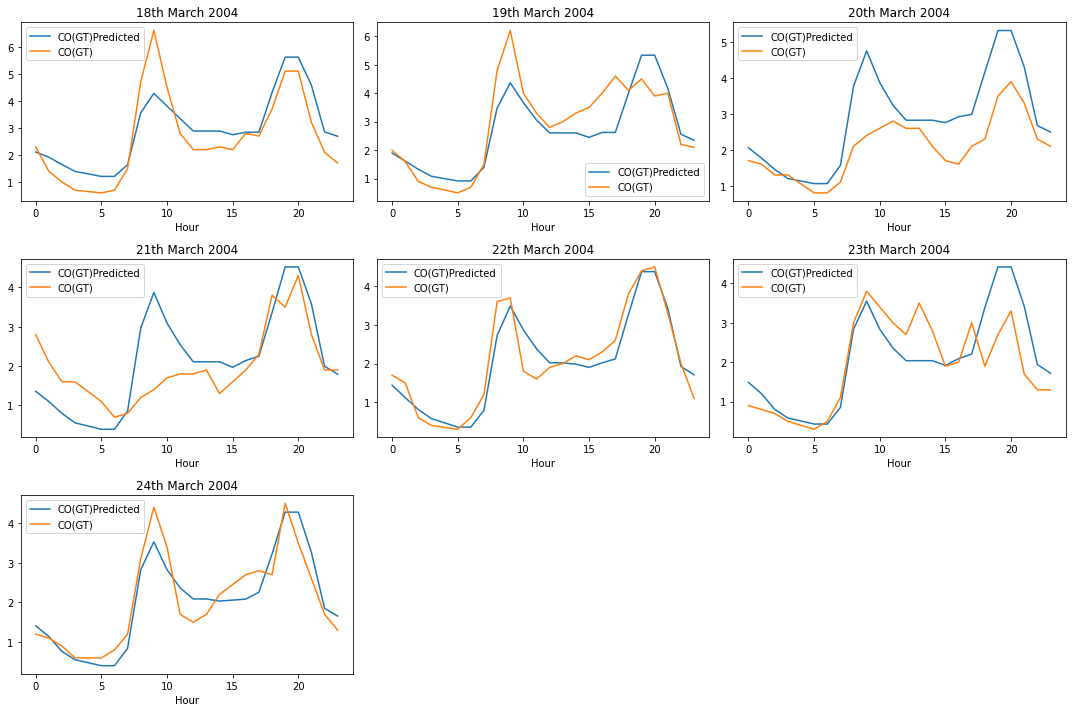

In [26]:
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    df2[df2['Day']==18+i].plot('Hour',['CO(GT)Predicted','CO(GT)'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

#### Visual Representation of Day-wise Temperature values  (Actual vs Predicted)

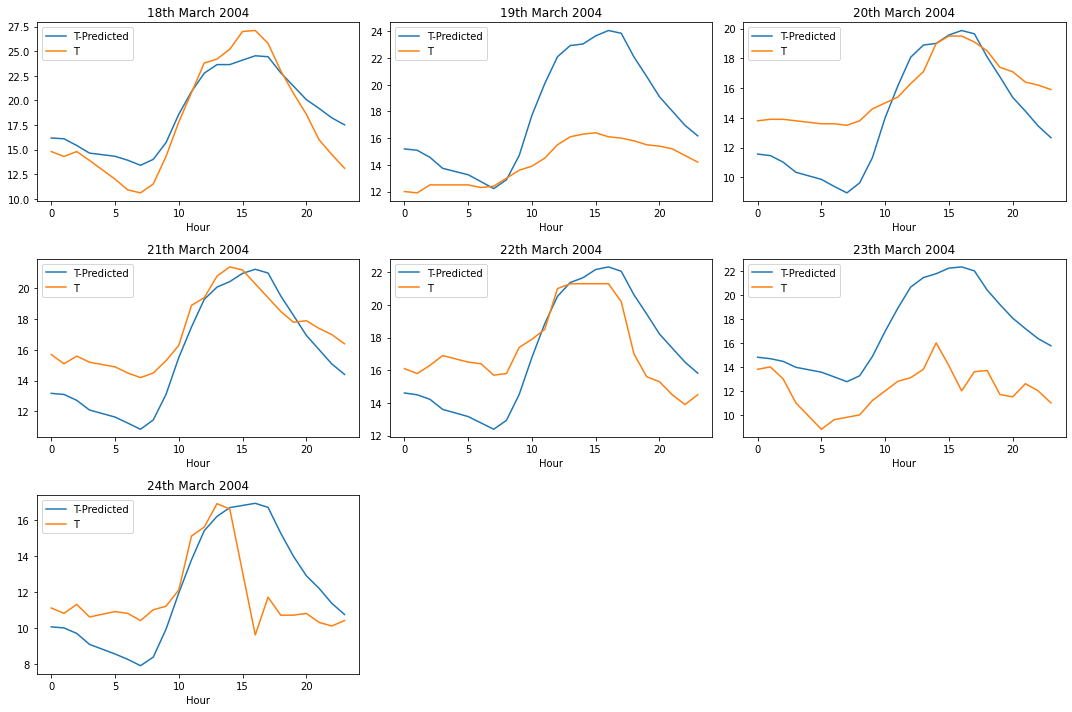

In [27]:
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    df2[df2['Day']==18+i].plot('Hour',['T-Predicted','T'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

### Predicting Temperature using Time Series Decomposition Method

<function matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)>

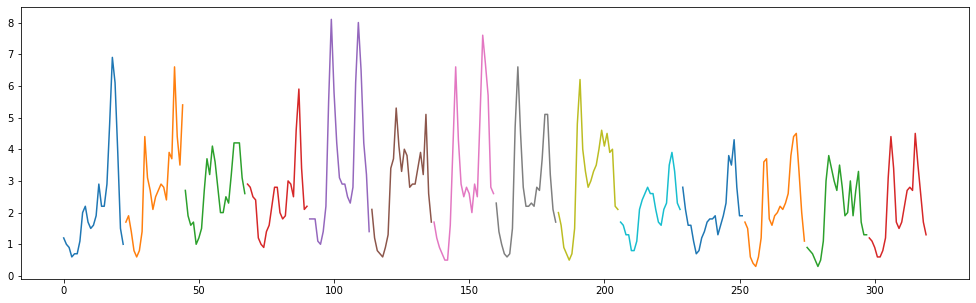

In [28]:
df1.groupby('Day')['CO(GT)'].plot(figsize=(17,5))
plt.autoscale

<function matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)>

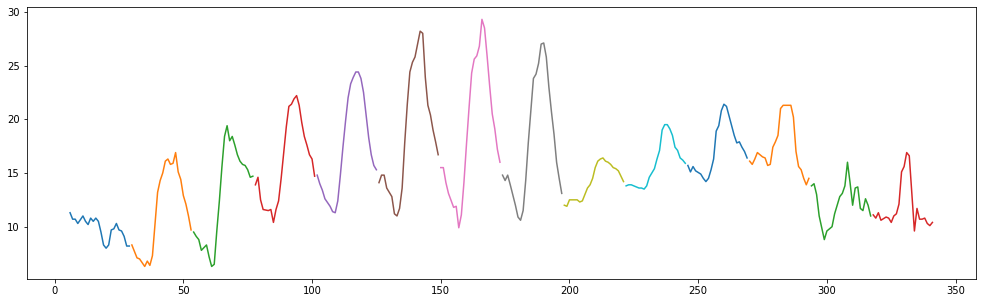

In [29]:
dfs.groupby('Day')['T'].plot(figsize=(17,5))
plt.autoscale

In [30]:
dfs['Date']=dfs['Date'].astype(str)
dfs.loc[:,'Date'] = pd.to_datetime(df.Date.astype(str)+' '+dfs.Time.astype(str),format='%Y-%m-%d %H.%M.%S')
dfs1 = dfs
dfs.index = dfs.Date
dfs=dfs['T']
dfs.head()

Date
2004-03-11 00:00:00    11.3
2004-03-11 01:00:00    10.7
2004-03-11 02:00:00    10.7
2004-03-11 03:00:00    10.3
2004-03-11 05:00:00    11.0
Name: T, dtype: float64

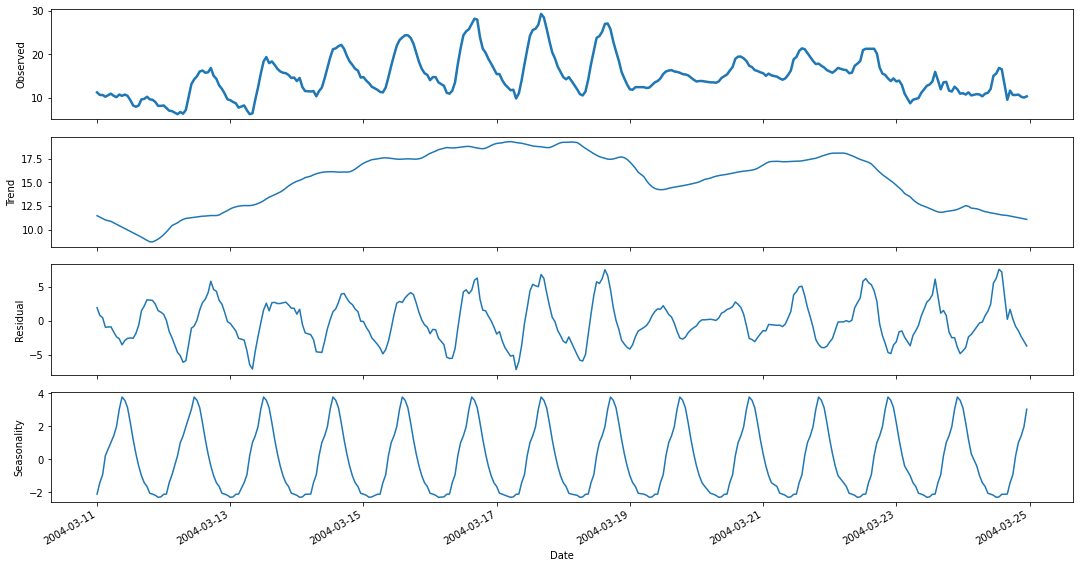

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(dfs,period=24,extrapolate_trend=1)
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8), sharex=True)
ax1.set_ylabel('Trend')
ax2.set_ylabel('Residual')
ax3.set_ylabel('Seasonality')
ax0.set_ylabel('Observed')
decompose_data.observed.plot(ax=ax0,linewidth=2.5)
decompose_data.trend.plot(ax=ax1)
decompose_data.resid.plot(ax=ax2)
decompose_data.seasonal.plot(ax=ax3)
plt.tight_layout()

<AxesSubplot:xlabel='Date'>

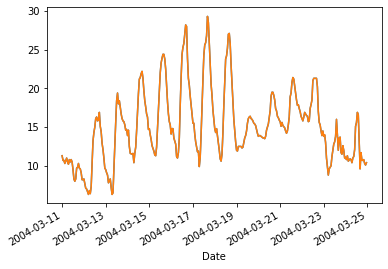

In [32]:
y = decompose_data.trend+decompose_data.resid+decompose_data.seasonal
ax = dfs.plot()
y.plot(ax=ax)

In [33]:
dfs1['Trend'] = decompose_data.trend;
dfs1['Residual'] = decompose_data.resid;
dfs1['Seasonality'] = decompose_data.seasonal;
dfs1['Temperature'] = dfs1[['T']]
dfs1= dfs1.reset_index(drop=True)

In [34]:
X_1, X_2 = dfs1[(mask:=df1['Day'] <= 17)].copy(), dfs1[~mask].copy()
c = X_1.columns.tolist()[4:]
Train = X_1[c]
Test = X_2[c]

Train.reset_index(drop=True,inplace=True)
Test.reset_index(drop=True,inplace=True)

In [35]:
x_train = Train[['Day','Hour']]
x_test =  Test[['Day','Hour']]
temp_test = Test[['Temperature']]
y_test =  Test[['Trend','Residual','Seasonality']]
y_train = Train[['Trend','Residual','Seasonality']]

In [37]:
y_train

,Trend,Residual,Seasonality
0,11.487500,1.909909,-2.097409
1,11.337500,0.767647,-1.405147
2,11.187500,0.446219,-0.933719
3,11.037500,-0.963156,0.225656
4,10.887500,-0.904079,1.016579
...,...,...,...
155,18.675000,2.221906,2.203094
156,18.775000,0.519021,1.205979
157,18.918750,-0.156620,0.337870
158,19.060417,-1.458223,-0.402194


In [38]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
UV = x_test['Day'].unique()
temp = 0;
result =[]

for i in UV:
    model1 = MultiOutputRegressor(xgb.XGBRegressor())
    model1.fit(x_train,y_train)
    testx = x_test[x_test["Day"] == i]
    testy = y_test[temp:temp+len(testx)]
    test1 = testx.to_numpy()
    x_train = x_train.append(testx, ignore_index=True)
    y_train = y_train.append(testy, ignore_index=True)
    resultx = model1.predict(test1)
    result.append(resultx)
    temp += len(testx)
print(result)

[array([[19.108467  , -1.9676546 , -1.6443149 ],
       [19.146328  , -1.5988997 , -2.04373   ],
       [19.179193  , -2.9766798 , -2.1003683 ],
       [19.247314  , -3.978111  , -2.1759465 ],
       [19.298546  , -5.204582  , -2.2948709 ],
       [19.26488   , -5.1022515 , -2.260309  ],
       [19.20881   , -7.1844172 , -2.1211867 ],
       [19.16785   , -5.9723115 , -2.088352  ],
       [19.127483  , -3.6335807 , -1.4163797 ],
       [19.061987  , -0.4183909 , -0.9190703 ],
       [18.986263  ,  1.8795424 ,  0.22498758],
       [18.901684  ,  4.3924284 ,  1.014006  ],
       [18.842678  ,  5.330592  ,  1.4122542 ],
       [18.804628  ,  5.1130743 ,  1.9820633 ],
       [18.788694  ,  4.9969463 ,  3.0326686 ],
       [18.751356  ,  6.77023   ,  3.7669067 ],
       [18.71381   ,  6.2280617 ,  3.566783  ],
       [18.669518  ,  4.0977745 ,  3.1228359 ],
       [18.675545  ,  2.2181792 ,  2.198175  ],
       [18.77283   ,  0.53066486,  1.2121547 ],
       [18.920698  , -0.15978208,  0.33

In [39]:
results = []
for i in result:
    for j in i:
        results.append(j)
result = results

In [40]:
dfnew2 = pd.DataFrame([], columns=['Day', 'Hours', 'Trend (Actual)', 'Residual (Actual)', 'Seasonality (Actual)',
                                  'T (Actual)', 'Trend (predicted)', 'Residual (predicted)', 'Seasonality (predicted)', 
                                 'T (predicted)', 'Trend (error)', 'Residual (error)', 'Seasonality (error)',
                               'T (error)' ])

mape_trend = {
    18: [0, 0],
    19: [0, 0],
    20: [0, 0],
    21: [0, 0],
    22: [0, 0],
    23: [0, 0],
    24: [0, 0],
}

mape_residual = {
    18: [0, 0],
    19: [0, 0],
    20: [0, 0],
    21: [0, 0],
    22: [0, 0],
    23: [0, 0],
    24: [0, 0],
}

mape_seasonality = {
    18: [0, 0],
    19: [0, 0],
    20: [0, 0],
    21: [0, 0],
    22: [0, 0],
    23: [0, 0],
    24: [0, 0],
}

mape_temp = {
    18: [0, 0],
    19: [0, 0],
    20: [0, 0],
    21: [0, 0],
    22: [0, 0],
    23: [0, 0],
    24: [0, 0],
}

In [41]:
for i in range(0, 160):
    trend_error = abs(abs(y_test.loc[i, ['Trend']][0] - result[i][0])/y_test.loc[i, ['Trend']][0])
    res_error = abs(abs(y_test.loc[i, ['Residual']][0] - result[i][1])/y_test.loc[i, ['Residual']][0])
    season_error = abs(abs(y_test.loc[i, ['Seasonality']][0] - result[i][2])/y_test.loc[i, ['Seasonality']][0])
    temp_actual = temp_test.loc[i, ['Temperature']][0]
    temp_pred = result[i][0] + result[i][1] + result[i][2]
    temp_error = abs(temp_actual - temp_pred)/temp_actual
    day = x_test.loc[i, ['Day']][0]
    mape_trend[day][0] += trend_error
    mape_trend[day][1] += 1
    mape_residual[day][0] += res_error
    mape_residual[day][1] += 1
    mape_seasonality[day][0] += season_error
    mape_seasonality[day][1] += 1
    mape_temp[day][0] += temp_error
    mape_temp[day][1] += 1
    dfx = pd.DataFrame([[x_test.loc[i, ['Day']][0], x_test.loc[i, ['Hour']][0], y_test.loc[i, ['Trend']][0], y_test.loc[i, ['Residual']][0], y_test.loc[i, ['Seasonality']][0], temp_actual, result[i][0], result[i][1], result[i][2], temp_pred, trend_error, res_error, season_error, temp_error]],columns=['Day', 'Hours', 'Trend (Actual)', 'Residual (Actual)', 'Seasonality (Actual)',
                                  'T (Actual)', 'Trend (predicted)', 'Residual (predicted)', 'Seasonality (predicted)', 
                                  'T (predicted)', 'Trend (error)', 'Residual (error)', 'Seasonality (error)', 'T (error)'] )
    dfnew2 = dfnew2.append(dfx, ignore_index=True)

In [42]:
dfnew2.to_csv('decompositionResults.csv')

In [43]:
dfnew2

,Day,Hours,Trend (Actual),Residual (Actual),Seasonality (Actual),T (Actual),Trend (predicted),Residual (predicted),Seasonality (predicted),T (predicted),Trend (error),Residual (error),Seasonality (error),T (error)
0,18,0,19.235417,-3.024569,-1.410848,14.8,19.108467,-1.967655,-1.644315,15.496497,0.006600,0.349443,0.165480,0.047061
1,18,1,19.225000,-3.284024,-1.640976,14.3,19.146328,-1.598900,-2.043730,15.503698,0.004092,0.513128,0.245436,0.084175
2,18,2,19.239583,-2.391396,-2.048188,14.8,19.179193,-2.976680,-2.100368,14.102146,0.003139,0.244746,0.025477,0.047152
3,18,3,19.268750,-3.267518,-2.101232,13.9,19.247314,-3.978111,-2.175946,13.093257,0.001112,0.217472,0.035557,0.058039
4,18,5,19.202083,-5.029537,-2.172547,12.0,19.298546,-5.204582,-2.294871,11.799093,0.005024,0.034803,0.056305,0.016742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,24,19,11.333333,-0.858990,0.225656,10.7,11.970242,-1.665910,1.420513,11.724845,0.056198,0.939383,5.295029,0.095780
156,24,20,11.275000,-1.491579,1.016579,10.8,12.024395,-2.496776,1.978179,11.505798,0.066465,0.673915,0.945918,0.065352
157,24,21,11.216667,-2.339049,1.422382,10.3,12.072891,-2.516363,3.035238,12.591766,0.076335,0.075806,1.133911,0.222502
158,24,22,11.158333,-3.035180,1.976847,10.1,12.151803,-3.919042,3.762258,11.995019,0.089034,0.291206,0.903161,0.187626


In [44]:
mean_mapeTrend = 0
for x in mape_trend:
    mean_mapeTrend += mape_trend[x][0]/mape_trend[x][1]
    print(f"MAPE of Trend for day {x} = {mape_trend[x][0]/mape_trend[x][1]}")

print(f"Mean MAPE of Trend: {mean_mapeTrend/7}")

mean_mapeRes = 0
for x in mape_seasonality:
    mean_mapeRes += mape_residual[x][0]/mape_residual[x][1]
    print(f"MAPE of Residual for day {x} = {mape_residual[x][0]/mape_residual[x][1]}")

print(f"Mean MAPE of Residual: {mean_mapeRes/7}")

mean_mapeSeason = 0
for x in mape_residual:
    mean_mapeSeason += mape_seasonality[x][0]/mape_seasonality[x][1]
    print(f"MAPE of Seasonality for day {x} = {mape_seasonality[x][0]/mape_seasonality[x][1]}")

print(f"Mean MAPE of Seasonality: {mean_mapeSeason/7}")

mean_mapeTemp = 0
for x in mape_temp:
    mean_mapeTemp += mape_temp[x][0]/mape_temp[x][1]
    print(f"MAPE of Temperature for day {x} = {mape_temp[x][0]/mape_temp[x][1]}")

print(f"Mean MAPE of Temperature: {mean_mapeTemp/7}")

MAPE of Trend for day 18 = 0.04705975576368254
MAPE of Trend for day 19 = 0.2162401281685696
MAPE of Trend for day 20 = 0.090060931513712
MAPE of Trend for day 21 = 0.08495466375778897
MAPE of Trend for day 22 = 0.06349069765704511
MAPE of Trend for day 23 = 0.34601347710167263
MAPE of Trend for day 24 = 0.07923001309303437
Mean MAPE of Trend: 0.13243566672221502
MAPE of Residual for day 18 = 3.9692237915724764
MAPE of Residual for day 19 = 5.589049509671146
MAPE of Residual for day 20 = 3.730655060637165
MAPE of Residual for day 21 = 0.6839641545607481
MAPE of Residual for day 22 = 9.331536674124406
MAPE of Residual for day 23 = 0.7653684531587442
MAPE of Residual for day 24 = 1.3873416980358073
Mean MAPE of Residual: 3.63673419168007
MAPE of Seasonality for day 18 = 0.5603216545316825
MAPE of Seasonality for day 19 = 0.5153910608787443
MAPE of Seasonality for day 20 = 0.4834800125649914
MAPE of Seasonality for day 21 = 0.5494772296178277
MAPE of Seasonality for day 22 = 0.55827886806

In [45]:
df3 = Test;
df3['Trend (predicted)'] = dfnew2.loc[:,['Trend (predicted)']]
df3['Residual (predicted)'] =  dfnew2.loc[:,['Residual (predicted)']]
df3['Seasonality (predicted)'] =  dfnew2.loc[:,['Seasonality (predicted)']]
df3['Temperature (predicted)'] =  dfnew2.loc[:,['T (predicted)']]

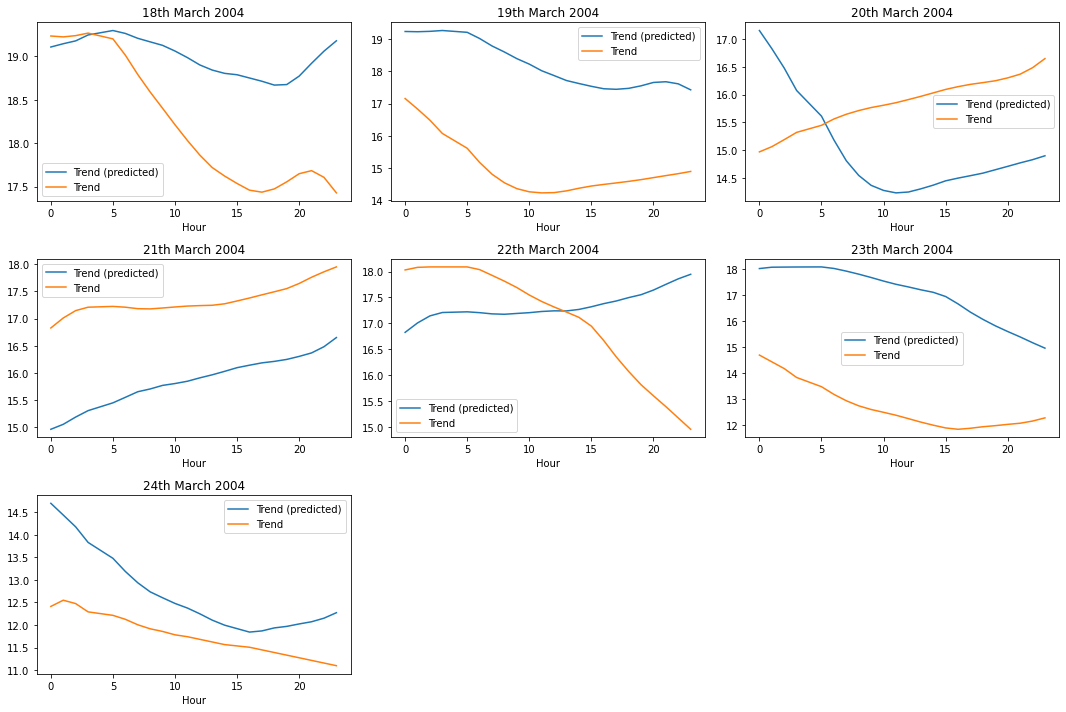

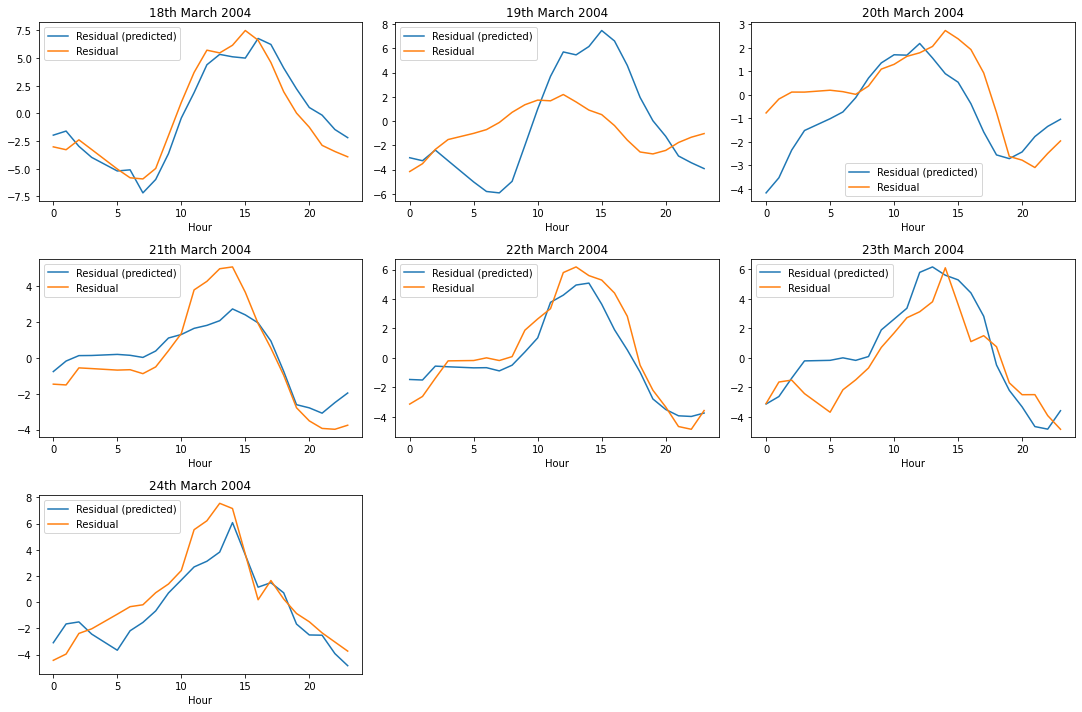

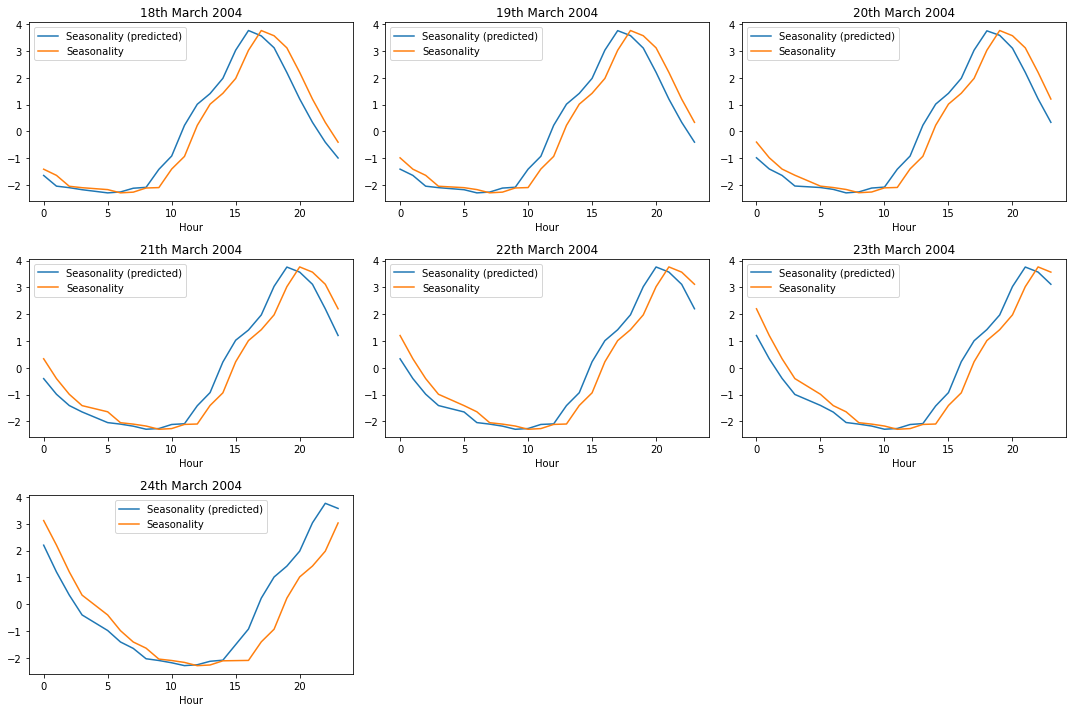

In [46]:
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    df3[df3['Day']==18+i].plot('Hour',['Trend (predicted)','Trend'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    df3[df3['Day']==18+i].plot('Hour',['Residual (predicted)','Residual'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    df3[df3['Day']==18+i].plot('Hour',['Seasonality (predicted)','Seasonality'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

In [47]:
dfnew['T-Decomposition (predicted)'] = dfnew2.loc[:,['T (predicted)']]
dfnew['T-Decomposition (error)'] = dfnew2.loc[:,['T (error)']]

In [49]:
dfnew.to_csv('finalResults.csv')

In [50]:
dfnew.head()

,Day,Hours,CO (Actual),T(Actual),CO(predicted),T(predicted),C (error),T (error),T-Decomposition (predicted),T-Decomposition (error)
0,18,0,2.3,14.8,2.110326,16.177864,0.082467,0.093099,15.496497,0.047061
1,18,1,1.4,14.3,1.919442,16.098240,0.371030,0.125751,15.503698,0.084175
2,18,2,1.0,14.8,1.647127,15.417482,0.647127,0.041722,14.102146,0.047152
3,18,3,0.7,13.9,1.393692,14.642238,0.990988,0.053398,13.093257,0.058039
4,18,5,0.6,12.0,1.208716,14.319855,1.014527,0.193321,11.799093,0.016742


<h2><center>Thank You<center></h2>
